# Evaluating ability to account for other machines

Notebook to investigate the ability to use predictions from the CNN and to feed them into a secondary model to predict other machine pull times.

In [1]:
import os
import time

from collections import defaultdict
from tempfile import NamedTemporaryFile
from typing import List, Tuple

import requests
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.metrics import mean_squared_error, mean_absolute_error

from optpresso import __file__ as optpresso_path
from optpresso.utils import GroundsLoader
from optpresso.data.config import load_config
from optpresso.data.partition import find_test_paths
from optpresso.models.serialization import load_model

from IPython.core.display import display

In [2]:
# Disable GPU, fast enough without
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# Path to alternative machine data
DATA_DIR = os.path.expanduser("~/breville/")
DATA_DOWNLOAD_URL = "https://docs.google.com/spreadsheets/d/1dDfuIq74pjELNtfb_0sdiNnG3qFKrfqC2sax7ewrWYg/export?format=csv&gid=1013114014"
OPTPRESSO_DIR = os.path.dirname(optpresso_path)
config = load_config()
if config is None:
    print("Invalid config, call optpresso init")
    raise ValueError("Invalid config")
model = load_model(config.model, compile=False)

images_by_time = defaultdict(list)
for time, img_path in find_test_paths(DATA_DIR):
    images_by_time[time].append(img_path)
for key in images_by_time.keys():
    images_by_time[key].sort()

In [3]:
with NamedTemporaryFile(suffix=".csv") as temp:
    with open(temp.name, "wb") as ofs:
        resp = requests.get(DATA_DOWNLOAD_URL, stream=True)
        for chunk in resp.iter_content():
            ofs.write(chunk)
    df = pd.read_csv(temp.name)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '').str.replace('(', '').str.replace(')', '')

### A bit of hacky code to associate CSV data with the relevant file paths

Relies on the timestamps in the file names and the fact that pulls take about 60 seconds 

In [4]:
counts = defaultdict(int)

def split_with_interval(paths: List[str], cutoff: int = 60) -> Tuple[List[str], List[str]]:
    last_time = None
    i = 0
    for i, path in enumerate(paths):
        if "flip" in path:
            continue
        timestamp = os.path.basename(path).split("-")[0]
        if not timestamp.isdigit():
            raise RuntimeError(f"{path} doesn't start with timestamp!")
        timestamp = int(timestamp)
        if last_time is not None and abs(timestamp - last_time) > cutoff:
            break
        last_time = timestamp
    return paths[:i], paths[i:]

chunks = defaultdict(list)
for pull, paths in images_by_time.items():
    last_time = None
    interval_paths, leftover = split_with_interval(paths)
    while len(interval_paths):
        chunks[pull].append(interval_paths)
        interval_paths, leftover = split_with_interval(leftover)

last_index_per_time = defaultdict(int)
predictions = []
for row in df.values:
    pull_time = row[2]
    chunk_idx = last_index_per_time[pull_time]
    loader = GroundsLoader(128, (model.input_shape[1], model.input_shape[2]), paths=chunks[pull_time][chunk_idx])
    predictions.append(model.predict(loader.get_batch(0, len(loader))[0]).squeeze())
    last_index_per_time[pull_time] += 1
for pull, idx in last_index_per_time.items():
    if len(chunks[pull]) != idx:
        raise ValueError(f"Didn't consume all chunks: {pull} has {len(chunks[pull])}, and only used {idx}")
df["predictions"] = predictions

In [5]:
# Do an 80:20 cross validation split
train = df.sample(frac=0.8)
test = df.drop(train.index)

In [6]:
train

,ingrams,outgrams,timeseconds,coffee,grinder,grindsetting,ratio,predictions
11,16.9,54.8,23,Candlestick - Columbia,Breville,7,3.24,"[15.779174, 13.930941, 14.72639, 15.514028, 13..."
5,16.0,50.0,29,Candlestick - Columbia,Breville,5,3.13,"[10.218912, 9.751541, 10.092384, 11.050295, 12..."
19,14.8,59.6,20,Candlestick - Columbia,Breville,9,4.03,"[12.194033, 12.186956, 7.460268, 13.257147, 14..."
9,14.6,58.5,21,Candlestick - Columbia,Breville,6,4.01,"[4.459337, 6.9460354, 6.0368404, 8.613329, 6.0..."
16,16.2,59.1,20,Candlestick - Columbia,Breville,8,3.65,"[8.201208, 6.8732586, 5.796999, 9.852135, 9.69..."
7,15.3,54.6,22,Candlestick - Columbia,Breville,5,3.57,"[9.546022, 7.7493896, 10.001963, 6.3291397, 7...."
1,12.8,46.4,38,Candlestick - Columbia,Breville,1,3.63,"[18.95369, 17.31194, 25.804546, 27.548199, 17...."
21,19.4,55.7,22,Candlestick - Columbia,Breville,10,2.87,"[12.236147, 12.646296, 8.515886, 12.971914, 16..."
22,14.6,54.2,18,Candlestick - Columbia,Breville,10,3.71,"[14.109436, 9.865282, 4.8333073, 6.3849125, 9...."
17,19.8,60.1,25,Candlestick - Columbia,Breville,9,3.04,"[12.599123, 8.892229, 8.493526, 10.213783, 8.5..."


## Evaluate using Gaussian Process to make predictions

It is feasible to build a personalized Gaussian Process (GP) model, and this is to do a basic proof of concept to see if it isn't totally worthless.

With Dropped columns: None


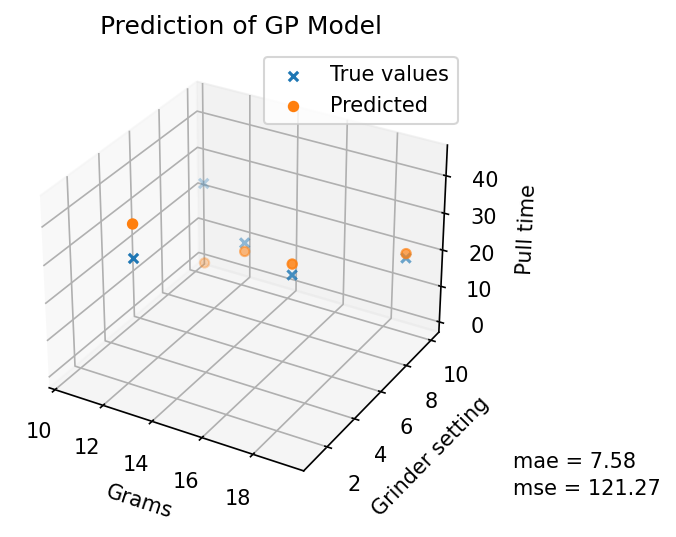

With Dropped columns: ('predictions',)


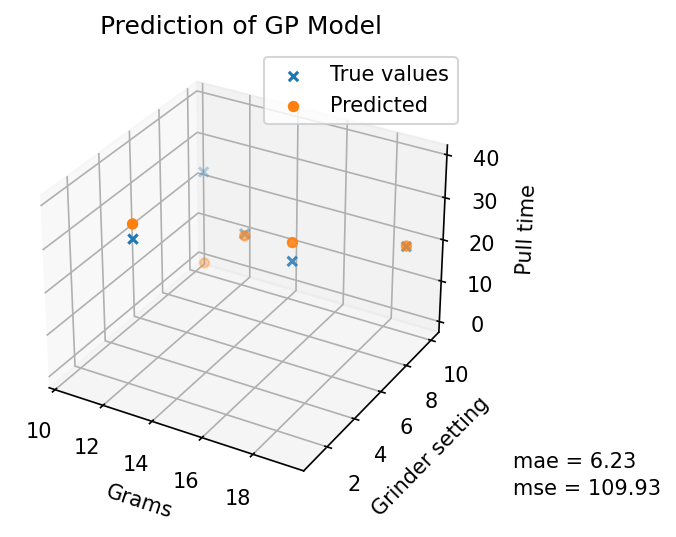

In [7]:
def prepare_df_for_gp(frame, prediction_column="timeseconds", encoded_cols=("grinder", "coffee"), drop_cols=None):
    if drop_cols is None:
        drop_cols = []
    new_frame = frame.copy(deep=True)
    for col in drop_cols:
        new_frame = new_frame.drop([col], axis=1)
    for col in encoded_cols:
        if col not in new_frame:
            print("No such column:", col)
            continue
        encoder = OneHotEncoder(handle_unknown="ignore")
        new_frame[col] = encoder.fit_transform(np.asarray(new_frame[col]).reshape(-1, 1)).toarray()
    
    y = np.asarray(new_frame[prediction_column])
    new_frame = new_frame.drop([prediction_column, "ratio"], axis=1)
    x = np.zeros((len(new_frame), len(new_frame.columns)), dtype=object)
    col_idxs = {}
    for i in range(len(new_frame)):
        for j, col in enumerate(sorted(new_frame.columns)):
            col_idxs[col] = j
            vals = np.asarray(new_frame[col].values[i])
            if isinstance(vals, np.ndarray) and col not in encoded_cols:
                x[i][j] = np.mean(vals)
            else:
                x[i][j] = vals
    return col_idxs, x, y

for dropped in [None, ("predictions", )]:
    print("With Dropped columns:", dropped)
    idxs, x, y = prepare_df_for_gp(train, drop_cols=dropped)
    gp = GaussianProcessRegressor(kernel=DotProduct() + WhiteKernel(), n_restarts_optimizer=9)
    gp.fit(x, y)
    _, x_val, y_val = prepare_df_for_gp(test, drop_cols=dropped)
    yfit, std_err = gp.predict(x_val, return_std=True)
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(111, projection="3d")
    ax.set_title("Prediction of GP Model")
    ax.set_xlabel("Grams")
    ax.set_ylabel("Grinder setting")
    ax.set_zlabel("Pull time")
    ax.scatter(
        x_val[:, idxs["ingrams"]],
        x_val[:, idxs["grindsetting"]],
        y_val,
        marker="x",
        label="True values",
    )
    ax.scatter(
        x_val[:, idxs["ingrams"]],
        x_val[:, idxs["grindsetting"]],
        yfit,
        marker="o",
        label="Predicted",
    )
    ax.legend()
    ax.annotate(
        "mse = {:.2f}".format(mean_squared_error(y_val, yfit)),
        (1.1, 0.01),
        xycoords="axes fraction",
    )
    ax.annotate(
        "mae = {:.2f}".format(mean_absolute_error(y_val, yfit)),
        (1.1, 0.07),
        xycoords="axes fraction",
    )
    plt.show()